In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

In [16]:
twitter = pd.read_csv('twitter_cleaned_stemmed-2.csv', index_col=False)
reddit = pd.read_csv('reddit_cleaned_stemmed.csv', index_col=False)

## Data Pre-processing

In [17]:
# Remove unnecessary columns
reddit.drop({'Unnamed: 0.1', 'Unnamed: 0'}, axis=1, inplace=True)
twitter.drop({'Unnamed: 0'}, axis=1, inplace=True)

# Rename columns
twitter.rename(columns={'Tweet': 'text', 'Suicide': 'class'}, inplace=True)

# Drop rows with missing value
reddit.dropna(how='any', inplace=True)
twitter.dropna(how='any', inplace=True)

# Convert text class to 0 / 1
le = LabelEncoder()
reddit['class'] = le.fit_transform(reddit['class'])

Train test split

In [18]:
# Splitting data into training and testing set
X_twitter = twitter['text']
y_twitter = twitter['class']

X_reddit = reddit['text']
y_reddit = reddit['class']

X_trainreddit, X_testreddit, y_trainreddit, y_testreddit = train_test_split(X_reddit, y_reddit, test_size=0.2, random_state=42)
X_traintwitter, X_testtwitter, y_traintwitter, y_testtwitter = train_test_split(X_twitter, y_twitter, test_size=0.2, random_state=42)

Tokenization

In [63]:
# Defining pre-processing parameters
max_len = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500


tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_trainreddit)

Padding: Reddit Dataset

In [64]:
x_reddit_training_sequences = tokenizer.texts_to_sequences(X_trainreddit)
x_reddit_training_padded = pad_sequences(x_reddit_training_sequences,
                                         maxlen = max_len,
                                         padding = padding_type,
                                         truncating = trunc_type)

x_reddit_testing_sequences = tokenizer.texts_to_sequences(X_testreddit)
x_reddit_testing_padded = pad_sequences(x_reddit_testing_sequences,
                                        maxlen = max_len,
                                        padding = padding_type,
                                        truncating = trunc_type)

Padding: Twitter Dataset

In [65]:
x_twitter_training_sequences = tokenizer.texts_to_sequences(X_traintwitter)
x_twitter_training_padded = pad_sequences(x_twitter_training_sequences,
                                          maxlen = max_len,
                                          padding = padding_type,
                                          truncating = trunc_type)


x_twitter_testing_sequences = tokenizer.texts_to_sequences(X_testtwitter)
x_twitter_testing_padded = pad_sequences(x_twitter_testing_sequences,
                                         maxlen = max_len,
                                         padding = padding_type,
                                         truncating = trunc_type)

## Deep learning model training

In [82]:
model_biGRU_LSTM = Sequential()
model_biGRU_LSTM.add(Embedding(input_dim=500, output_dim=100, input_length=256, name='layer_embedding'))
model_biGRU_LSTM.add(Bidirectional(GRU(16, return_sequences=True)))
model_biGRU_LSTM.add(Bidirectional(LSTM(8, return_sequences=True)))
model_biGRU_LSTM.add(Bidirectional(GRU(4, return_sequences=True)))
model_biGRU_LSTM.add(Bidirectional(GRU(2)))
model_biGRU_LSTM.add(Dropout(0.2))
model_biGRU_LSTM.add(Dense(1, activation='sigmoid'))
model_biGRU_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model_biGRU_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding  (None, 256, 100)          50000     
 )                                                               
                                                                 
 bidirectional_28 (Bidirect  (None, 256, 32)           11328     
 ional)                                                          
                                                                 
 bidirectional_29 (Bidirect  (None, 256, 16)           2624      
 ional)                                                          
                                                                 
 bidirectional_30 (Bidirect  (None, 256, 8)            528       
 ional)                                                          
                                                                 
 bidirectional_31 (Bidirect  (None, 4)                

### BiGRU Model Training on Reddit Dataset

Reddit Training Set

In [83]:
history_reddittrain = model_biGRU_LSTM.fit(x_reddit_training_padded, y_trainreddit, batch_size=64, epochs=10)

Epoch 1/10
2900/2900 [==============================] - 324s 111ms/step - loss: 0.3019 - accuracy: 0.8847
Epoch 2/10
2900/2900 [==============================] - 317s 109ms/step - loss: 0.2626 - accuracy: 0.8960
Epoch 3/10
2900/2900 [==============================] - 316s 109ms/step - loss: 0.2546 - accuracy: 0.9003
Epoch 4/10
2900/2900 [==============================] - 319s 110ms/step - loss: 0.2383 - accuracy: 0.9137
Epoch 5/10
2900/2900 [==============================] - 315s 109ms/step - loss: 0.2267 - accuracy: 0.9167
Epoch 6/10
2900/2900 [==============================] - 318s 110ms/step - loss: 0.2207 - accuracy: 0.9190
Epoch 7/10
2900/2900 [==============================] - 316s 109ms/step - loss: 0.2177 - accuracy: 0.9199
Epoch 8/10
2900/2900 [==============================] - 318s 110ms/step - loss: 0.2142 - accuracy: 0.9215
Epoch 9/10
2900/2900 [==============================] - 318s 110ms/step - loss: 0.2117 - accuracy: 0.9221
Epoch 10/10
2900/2900 [=======================

Evaluation: Reddit Training Set | Reddit Testing Set

In [84]:
y_predreddit_bigru = model_biGRU_LSTM.predict(x_reddit_testing_padded)
y_predreddit_bigru_processed = np.round(y_predreddit_bigru)

precisionreddit80tfidfbigru = precision_score(y_testreddit, y_predreddit_bigru_processed)
recallreddit80tfidfbigru = recall_score(y_testreddit, y_predreddit_bigru_processed)
f1reddit80tfidfbigru = f1_score(y_testreddit, y_predreddit_bigru_processed)
accuracyreddit80tfidfbigru = accuracy_score(y_testreddit, y_predreddit_bigru_processed)


print("Precision:", precisionreddit80tfidfbigru)
print("Recall:", recallreddit80tfidfbigru)
print("F1 Score:", f1reddit80tfidfbigru)
print("Accuracy:", accuracyreddit80tfidfbigru)

1450/1450 [==============================] - 27s 18ms/step
Precision: 0.934432805883664
Recall: 0.9026868756458836
F1 Score: 0.918285551588953
Accuracy: 0.9195818514926177


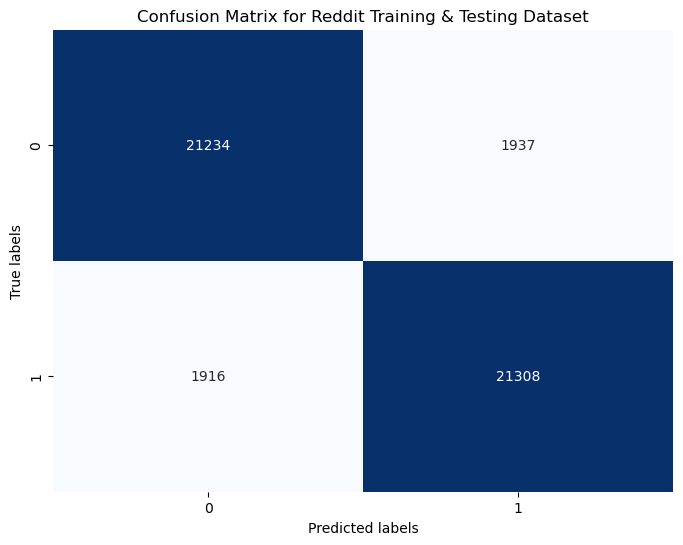

In [85]:
# Confusion Matrix
reddit_cm = confusion_matrix(y_testreddit, y_predreddit_bigru_processed)
plt.figure(figsize=(8, 6))
sns.heatmap(reddit80tfidfbigru_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Reddit Training & Testing Dataset")
plt.show()

Evaluation: Reddit Training Dataset | Twitter Testing Dataset

In [86]:
y_predreddit_bigru = model_biGRU_LSTM.predict(x_twitter_testing_padded)
y_predreddit_bigru_processed = np.round(y_predreddit_bigru)

precisionreddit80tfidfbigru = precision_score(y_testtwitter, y_predreddit_bigru_processed)
recallreddit80tfidfbigru = recall_score(y_testtwitter, y_predreddit_bigru_processed)
f1reddit80tfidfbigru = f1_score(y_testtwitter, y_predreddit_bigru_processed)
accuracyreddit80tfidfbigru = accuracy_score(y_testtwitter, y_predreddit_bigru_processed)


print("Precision:", precisionreddit80tfidfbigru)
print("Recall:", recallreddit80tfidfbigru)
print("F1 Score:", f1reddit80tfidfbigru)
print("Accuracy:", accuracyreddit80tfidfbigru)

68/68 [==============================] - 1s 18ms/step
Precision: 0.7470355731225297
Recall: 0.8059701492537313
F1 Score: 0.7753846153846154
Accuracy: 0.7985280588776449


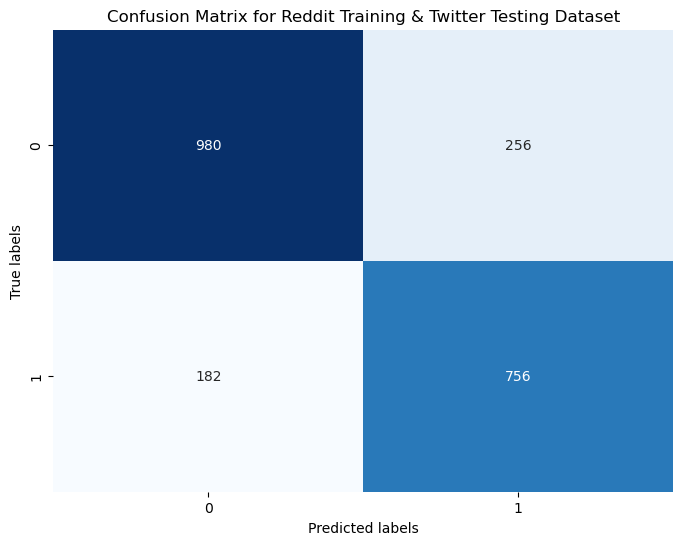

In [87]:
# Confusion Matrix
reddittrain_twittertest_cm = confusion_matrix(y_testtwitter, y_predreddit_bigru_processed)
plt.figure(figsize=(8, 6))
sns.heatmap(reddittrain_twittertest_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Reddit Training & Twitter Testing Dataset")
plt.show()

### BiGRU Model Training on Twitter Dataset

In [88]:
history_twittertrain = model_biGRU_LSTM.fit(x_twitter_training_padded, y_traintwitter, batch_size=64, epochs=10)

Epoch 1/10
136/136 [==============================] - 15s 109ms/step - loss: 0.3323 - accuracy: 0.8616
Epoch 2/10
136/136 [==============================] - 15s 110ms/step - loss: 0.2811 - accuracy: 0.8889
Epoch 3/10
136/136 [==============================] - 15s 111ms/step - loss: 0.2569 - accuracy: 0.8976
Epoch 4/10
136/136 [==============================] - 15s 109ms/step - loss: 0.2385 - accuracy: 0.9082
Epoch 5/10
136/136 [==============================] - 15s 109ms/step - loss: 0.2248 - accuracy: 0.9149
Epoch 6/10
136/136 [==============================] - 15s 110ms/step - loss: 0.2104 - accuracy: 0.9221
Epoch 7/10
136/136 [==============================] - 15s 110ms/step - loss: 0.1975 - accuracy: 0.9277
Epoch 8/10
136/136 [==============================] - 15s 110ms/step - loss: 0.1848 - accuracy: 0.9312
Epoch 9/10
136/136 [==============================] - 15s 110ms/step - loss: 0.1712 - accuracy: 0.9367
Epoch 10/10
136/136 [==============================] - 15s 109ms/step - l

Evaluation: Twitter Training | Twitter Testing

In [89]:
y_predreddit_bigru = model_biGRU_LSTM.predict(x_twitter_testing_padded)
y_predreddit_bigru_processed = np.round(y_predreddit_bigru)

precisionreddit80tfidfbigru = precision_score(y_testtwitter, y_predreddit_bigru_processed)
recallreddit80tfidfbigru = recall_score(y_testtwitter, y_predreddit_bigru_processed)
f1reddit80tfidfbigru = f1_score(y_testtwitter, y_predreddit_bigru_processed)
accuracyreddit80tfidfbigru = accuracy_score(y_testtwitter, y_predreddit_bigru_processed)


print("Precision:", precisionreddit80tfidfbigru)
print("Recall:", recallreddit80tfidfbigru)
print("F1 Score:", f1reddit80tfidfbigru)
print("Accuracy:", accuracyreddit80tfidfbigru)

68/68 [==============================] - 1s 18ms/step
Precision: 0.9131455399061033
Recall: 0.8294243070362474
F1 Score: 0.8692737430167599
Accuracy: 0.8923643054277829


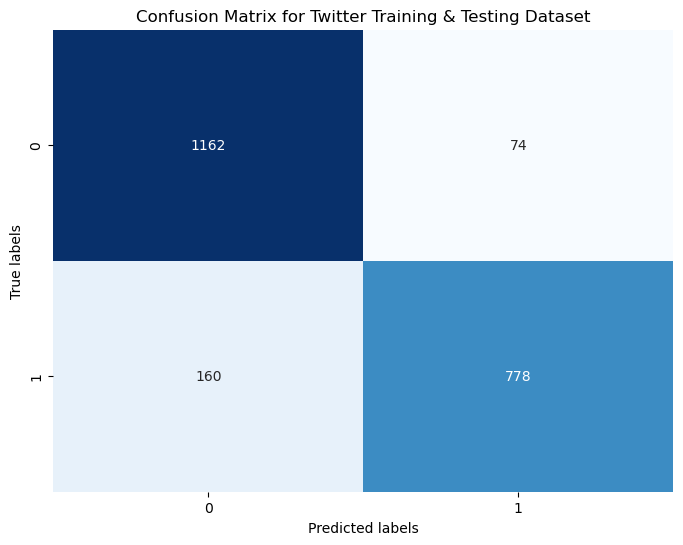

In [90]:
# Confusion Matrix
twitter_cm = confusion_matrix(y_testtwitter, y_predreddit_bigru_processed)
plt.figure(figsize=(8, 6))
sns.heatmap(twitter_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Twitter Training & Testing Dataset")
plt.show()

Evaluation: Twitter Training | Reddit Testing

In [91]:
y_predreddit_bigru = model_biGRU_LSTM.predict(x_reddit_testing_padded)
y_predreddit_bigru_processed = np.round(y_predreddit_bigru)

precisionreddit80tfidfbigru = precision_score(y_testreddit, y_predreddit_bigru_processed)
recallreddit80tfidfbigru = recall_score(y_testreddit, y_predreddit_bigru_processed)
f1reddit80tfidfbigru = f1_score(y_testreddit, y_predreddit_bigru_processed)
accuracyreddit80tfidfbigru = accuracy_score(y_testreddit, y_predreddit_bigru_processed)


print("Precision:", precisionreddit80tfidfbigru)
print("Recall:", recallreddit80tfidfbigru)
print("F1 Score:", f1reddit80tfidfbigru)
print("Accuracy:", accuracyreddit80tfidfbigru)

1450/1450 [==============================] - 26s 18ms/step
Precision: 0.682272
Recall: 0.9180589045814674
F1 Score: 0.7827954620552924
Accuracy: 0.7449725185903654


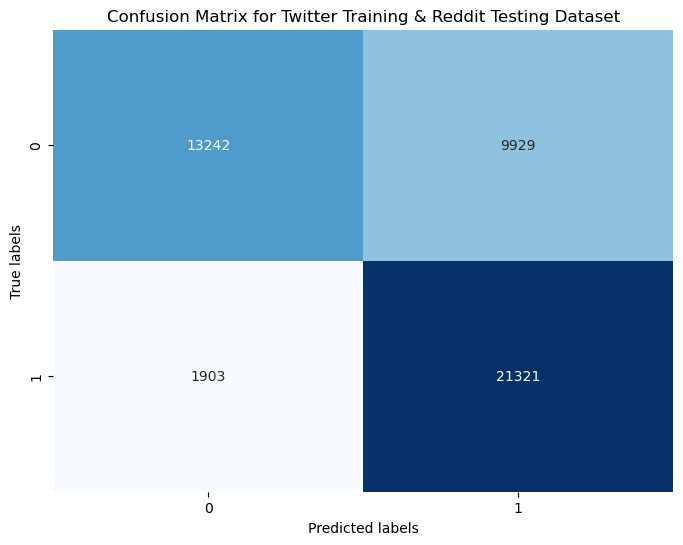

In [92]:
# Confusion Matrix
twittertraining_reddittesting_cm = confusion_matrix(y_testreddit, y_predreddit_bigru_processed)
plt.figure(figsize=(8, 6))
sns.heatmap(twittertraining_reddittesting_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Twitter Training & Reddit Testing Dataset")
plt.show()